## Imports

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os

import seaborn as sns
import matplotlib.pyplot as plt

## Caminhos utilizados no fluxo

In [7]:
input_path = '/home/murilo/workspace/tcc/tcc/python_model/database/x_test.csv'
output_path = '/home/murilo/workspace/tcc/tcc/python_model/database/y_test.csv'

model_paths = {
    "weights_only_quantized": "model_weights_only_quantized.tflite",
    "full_integer_quantized": "model_full_integer_quantized.tflite",
    "float16_quantized": "model_float16_quantized.tflite",
    "dynamic_range_quantized": "model_dynamic_range_quantized.tflite",
    "keras_model": "python_model.h5"
}

## Base de dados para teste

In [5]:
x_test = pd.read_csv(input_path).values
y_test = pd.read_csv(output_path).values.squeeze()

## Volumentria dos arquivos

In [8]:
model_sizes = {name: os.path.getsize(path) for name, path in model_paths.items()}
model_sizes

{'weights_only_quantized': 12184,
 'full_integer_quantized': 11512,
 'float16_quantized': 20176,
 'dynamic_range_quantized': 12184,
 'keras_model': 137112}

/tmp/ipykernel_6292/3355348780.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  size_plot = sns.barplot(x='Size (MB)', y='Model', data=data, palette='mako')


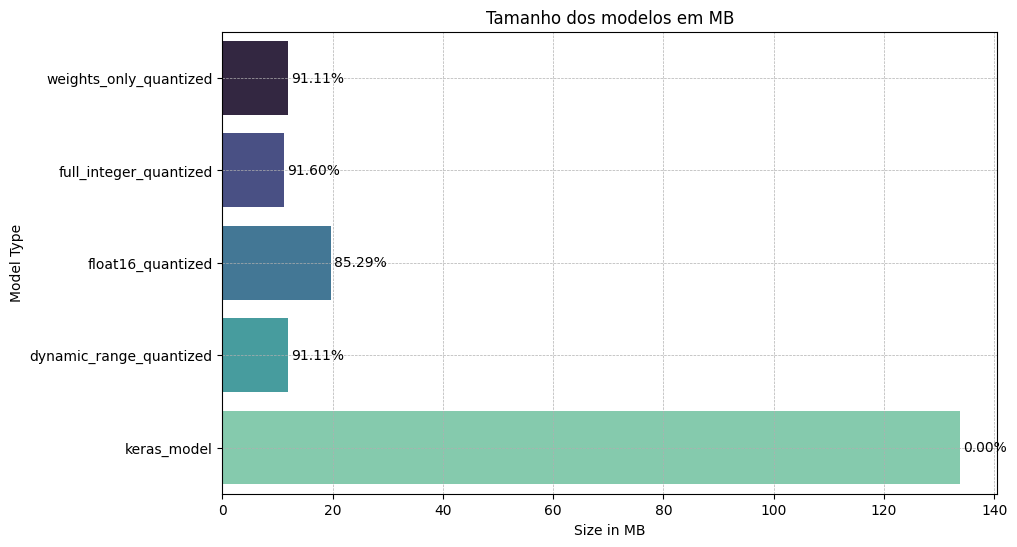

In [34]:
# Convertendo o dicionário para DataFrame para plotagem
data = pd.DataFrame(list(model_sizes.items()), columns=['Model', 'Size (KB)'])

# Convertendo os tamanhos para megabytes para melhor visualização
data['Size (MB)'] = data['Size (KB)'] / 1024

# Cálculo da redução percentual em relação ao modelo Keras
data['Reduction (%)'] = 100 - (data['Size (MB)'] / data['Size (MB)'].iloc[-1] * 100)

# Melhorando o gráfico de barras de tamanhos em MB
plt.figure(figsize=(10, 6))
size_plot = sns.barplot(x='Size (MB)', y='Model', data=data, palette='mako')
plt.title('Tamanho dos modelos em MB')
plt.xlabel('Size in MB')
plt.ylabel('Model Type')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adicionando as porcentagens de redução ao gráfico
for index, value in enumerate(data['Size (MB)']):
    plt.text(value + 0.5, index, f"{data['Reduction (%)'][index]:.2f}%", va='center')

plt.show()

## Precisão dos modelos

In [34]:
model_keras = tf.keras.models.load_model('python_model.h5')

start_time = time.time()
predictions_keras = model_keras.predict(x_test)
end_time = time.time()

predictions_keras = predictions_keras.squeeze()

mse_keras = np.mean((y_test - predictions_keras) ** 2)
mae_keras = np.mean(np.abs(y_test - predictions_keras))

print("Keras - MSE:", mse_keras, "MAE:", mae_keras, "Tempo de Inferência:", end_time - start_time)

2/2 [==============================] - 0s 2ms/step
Keras - MSE: 0.03406967624370865 MAE: 0.13253899328129368 Tempo de Inferência: 0.05826830863952637


In [35]:
tflite_models = {
    "dynamic_range": "model_dynamic_range_quantized.tflite",
    "float16": "model_float16_quantized.tflite",
    "full_integer": "model_full_integer_quantized.tflite",
    "weights_only": "model_weights_only_quantized.tflite"
}

interpreters = {}
for key, path in tflite_models.items():
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()
    interpreters[key] = interpreter

In [36]:
def evaluate_model(interpreter, x_test, y_test):
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    
    # Predições TFLite
    predictions = []
    start_time = time.time()
    for test_sample in x_test:
        # Assegurar que os dados estão no formato correto e dimensionados para o modelo
        test_sample = np.expand_dims(test_sample, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_sample)
        interpreter.invoke()
        predictions.append(interpreter.get_tensor(output_index)[0][0])
    end_time = time.time()
    
    mse = np.mean((y_test - np.array(predictions)) ** 2)
    mae = np.mean(np.abs(y_test - np.array(predictions)))

    return mse, mae, end_time - start_time

In [37]:
results = {}
for key, interpreter in interpreters.items():
    mse, mae, inference_time = evaluate_model(interpreter, x_test, y_test)
    results[key] = {
        "MSE": mse,
        "MAE": mae,
        "Tempo de Inferência": inference_time
    }
    print(f"{key} - MSE: {mse}, MAE: {mae}, Tempo de Inferência: {inference_time}")

dynamic_range - MSE: 0.03421646973055114, MAE: 0.13311932799901197, Tempo de Inferência: 0.001224517822265625
float16 - MSE: 0.034069540216803626, MAE: 0.13252876251654702, Tempo de Inferência: 0.0004630088806152344


ValueError: Cannot set tensor: Got value of type FLOAT32 but expected type INT8 for input 0, name: serving_default_dense_3_input:0 